# Reference model - test set: 3 domain features
# Table of contents 
1. [Linear Regression](#LinearRegression)
2. [MLP (Dense)](#MLP)
3. [AE combined latent](#AE_combined)
4. [AE OTU latent](#AE_latentOTU)

In [1]:
from data import *
from transfer_learning import *
from test_functions import *
from layers import *
from utils import *
from loss import *
from metric import *
from results import *
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers

Using TensorFlow backend.


In [2]:
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = \
    read_df_with_transfer_learning_subset_fewerDomainFeatures(['age','Temperature','Precipitation3Days'])

In [3]:
print(df_domain_train.shape)
print(df_domain_test.shape)

(4251, 3)
(373, 3)


In [4]:
print('TRAIN:')
print('age:' + str(df_domain_train.loc[:,'age'].mean()))
print('rain:' + str(df_domain_train.loc[:,'Precipitation3Days'].mean()))
print('Tª:' + str(df_domain_train.loc[:,'Temperature'].mean()))
    
print('TEST:')
print('age:' + str(df_domain_test.loc[:,'age'].mean()))
print('rain:' + str(df_domain_test.loc[:,'Precipitation3Days'].mean()))
print('Tª:' + str(df_domain_test.loc[:,'Temperature'].mean()))

TRAIN:
age:9.131498470948012
rain:0.4424182545283462
Tª:69.01096212655845
TEST:
age:9.091152815013405
rain:0.4129758713136729
Tª:69.06434316353888


### Get numpy transfer_learning objects

In [5]:
data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

# 1. Linear regression <a name="LinearRegression"></a>

In [6]:
def model(shape_in, shape_out, output_transform):
    in_layer = layers.Input(shape=(shape_in,))
    net = in_layer
    net = layers.Dense(shape_out, activation='linear')(net)
    if output_transform is not None:
        net = output_transform(net)
    out_layer = net
    
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    return model

def compile_model(model, optimizer, reconstruction_error, input_transform, output_transform):
    metrics = get_experiment_metrics(input_transform, output_transform)[0][3:]
    model.compile(optimizer=optimizer, loss=reconstruction_error, metrics=metrics)

In [7]:
def model_fn():
    m = model(shape_in=3,
              shape_out=717,
              output_transform=None)
    
    compile_model(model=m,
                  optimizer=optimizers.Adam(lr=0.001),
                  reconstruction_error=LossMeanSquaredErrorWrapper(CenterLogRatio(), None),
                  input_transform=CenterLogRatio(),
                  output_transform=None)
    return m, None, m, None

In [8]:
latent_space = 0
results, modelsLR = train(model_fn,
                        data_microbioma_train,
                        data_domain_train,
                        latent_space=latent_space,
                        folds=5,
                        epochs=100,
                        batch_size=64,
                        learning_rate_scheduler=None,
                        verbose=-1)

<p>Best iteration: <b>95</b></p>

<b>loss</b>: 4.1314 (min: 4.1200, max: 4.1434)

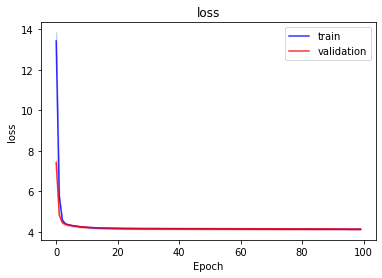

<b>domain_BrayCurtis</b>: 0.4549 (min: 0.4533, max: 0.4567)

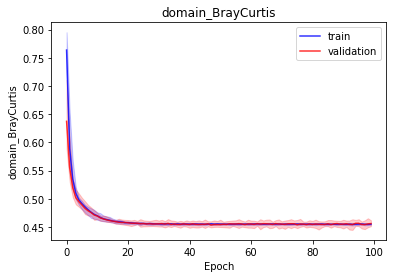

<b>domain_pearson_corr</b>: 0.6793 (min: 0.6764, max: 0.6809)

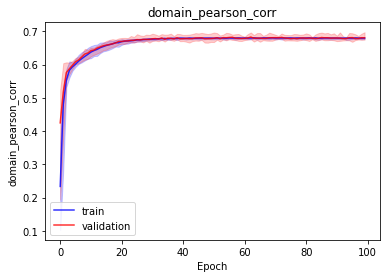

<b>domain_jensen_shannon_divergence</b>: 1.0326 (min: 1.0161, max: 1.0410)

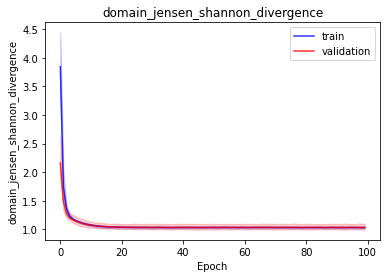

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 4.131393156756356 | 4.119962105222465 | 4.143375030405381 |
| domain_BrayCurtis | 0.4549470543861389 | 0.4533097743988037 | 0.45669081807136536 |
| domain_pearson_corr | 0.6793166995048523 | 0.6764175891876221 | 0.680908203125 |
| domain_jensen_shannon_divergence | 1.0326282978057861 | 1.016129493713379 | 1.0410072803497314 |


[('best_lost_epoch', 95),
 ('val_loss', [4.143468795503888, 4.101746712412153, 4.166701827730451]),
 ('val_domain_BrayCurtis', [0.45643988, 0.45140705, 0.46368194]),
 ('val_domain_pearson_corr', [0.6809522, 0.668237, 0.69401246]),
 ('val_domain_jensen_shannon_divergence', [1.0350869, 0.9990685, 1.0960093])]

In [9]:
print_results(results)

In [10]:
predictions = test_model(modelsLR, CenterLogRatio, None, data_microbioma_test, data_domain_test)
#save_predictions(predictions, 'experiment_testSet_linear_regresion_3var.txt')

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.46377038955688477 | 0.46300238370895386 | 0.46512389183044434 |
| pearson_corr | 0.6641077399253845 | 0.6610054969787598 | 0.6680633425712585 |
| jensen_shannon_divergence | 1.0097750425338745 | 1.005576491355896 | 1.0144600868225098 |


# 2. MLP (Dense) <a name="MLP"></a>

In [11]:
def model(shape_in, shape_out, output_transform, layers_list, activation_fn):
    in_layer = layers.Input(shape=(shape_in,))
    net = in_layer
    for s in layers_list:
        net = layers.Dense(s, activation=activation_fn)(net)
    net = layers.Dense(shape_out, activation='linear')(net)
    if output_transform is not None:
        net = output_transform(net)
    out_layer = net
    
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    return model

def compile_model(model, optimizer, reconstruction_error, input_transform, output_transform):
    metrics = get_experiment_metrics(input_transform, output_transform)[0][3:]
    model.compile(optimizer=optimizer, loss=reconstruction_error, metrics=metrics)

In [12]:
def model_fn():
    m = model(shape_in=3,
              shape_out=717,
              output_transform=None,
              layers_list=[128,512],
              activation_fn='tanh')
    
    compile_model(model=m,
                  optimizer=optimizers.Adam(lr=0.01),
                  reconstruction_error=LossMeanSquaredErrorWrapper(CenterLogRatio(), None),
                  input_transform=CenterLogRatio(),
                  output_transform=None)
    return m, None, m, None

In [13]:
latent_space=0
results, modelsMLP = train(model_fn,
                        data_microbioma_train,
                        data_domain_train,
                        latent_space=latent_space,
                        folds=5,
                        epochs=100,
                        batch_size=64,
                        learning_rate_scheduler=None,
                        verbose=-1)

<p>Best iteration: <b>19</b></p>

<b>loss</b>: 3.9538 (min: 3.9267, max: 3.9721)

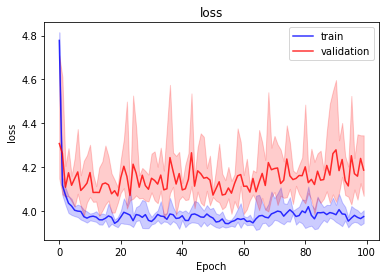

<b>domain_BrayCurtis</b>: 0.4334 (min: 0.4282, max: 0.4385)

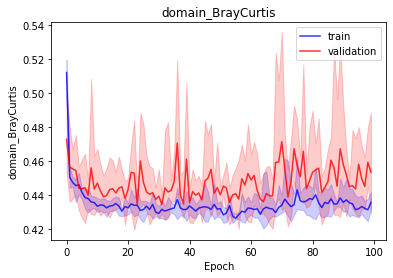

<b>domain_pearson_corr</b>: 0.7076 (min: 0.7000, max: 0.7122)

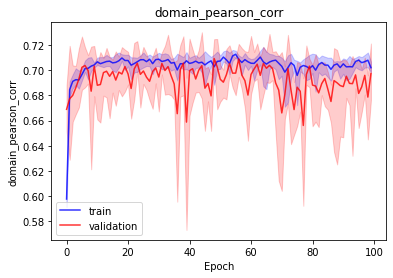

<b>domain_jensen_shannon_divergence</b>: 0.9516 (min: 0.9386, max: 0.9653)

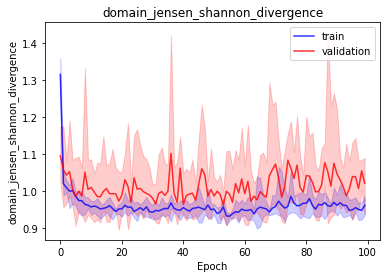

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 3.9537803048833675 | 3.926729926289057 | 3.9721488784341252 |
| domain_BrayCurtis | 0.43343478441238403 | 0.428228497505188 | 0.4385029375553131 |
| domain_pearson_corr | 0.7076407074928284 | 0.700007975101471 | 0.7121633291244507 |
| domain_jensen_shannon_divergence | 0.9516324996948242 | 0.9386004209518433 | 0.9652557969093323 |


[('best_lost_epoch', 19),
 ('val_loss', [4.069353461265564, 4.035871556827, 4.109771319798061]),
 ('val_domain_BrayCurtis', [0.43816024, 0.42254382, 0.4484565]),
 ('val_domain_pearson_corr', [0.70284534, 0.68303037, 0.7161877]),
 ('val_domain_jensen_shannon_divergence', [0.97286046, 0.89511853, 1.0529438])]

In [14]:
print_results(results)

In [15]:
predictions = test_model(modelsMLP, CenterLogRatio, None, data_microbioma_test, data_domain_test)
#save_predictions(predictions, 'experiment_testSet_MLP_3var.txt')

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.4527231752872467 | 0.4254830777645111 | 0.48674046993255615 |
| pearson_corr | 0.692674994468689 | 0.6713423132896423 | 0.7056561708450317 |
| jensen_shannon_divergence | 0.9654271006584167 | 0.8846358060836792 | 1.0573627948760986 |


# 3. Auto-encoder combined latent <a name="AE_combined"></a>

In [16]:
from train_2 import *

### Get microbioma train data and numpy train objects

In [17]:
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = \
    read_df_with_transfer_learning_subset_fewerDomainFeatures(['age','Temperature','Precipitation3Days'])

In [18]:
data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

In [19]:
data_domain_train.shape

(4251, 3)

### To create auto-encoder combined model

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 10 |
| Bioma Autoencoder | b -> 512 -> 256 -> 10 -> 256 -> 512 -> b |
| Domain Autoencoder | d -> 32 -> 16 -> 10 -> 256 -> 512 -> b |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 5 |
| Epochs | 100 |
| Batch Size | 64 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>99</b></p>

<b>loss</b>: 0.6267 (min: 0.6136, max: 0.6406)

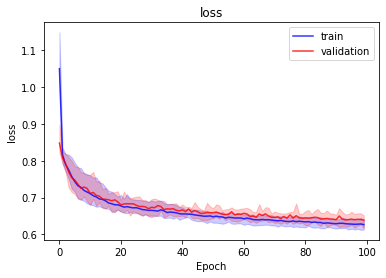

<b>bioma_loss</b>: 0.1977 (min: 0.1892, max: 0.2141)

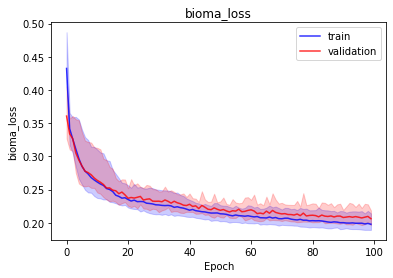

<b>domain_loss</b>: 0.4109 (min: 0.4078, max: 0.4151)

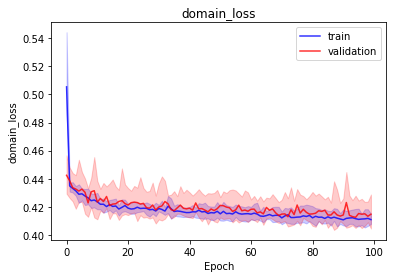

<b>latent_loss</b>: 0.0176 (min: 0.0162, max: 0.0197)

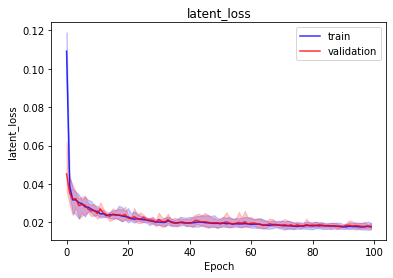

<b>bioma_mse</b>: 0.0000 (min: 0.0000, max: 0.0000)

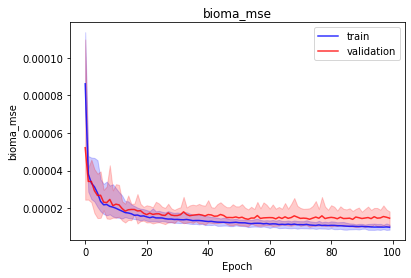

<b>bioma_mae</b>: 0.0005 (min: 0.0005, max: 0.0006)

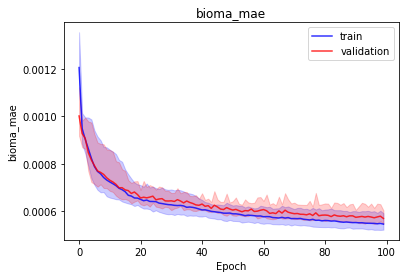

<b>bioma_mape</b>: 4800.5063 (min: 4455.9458, max: 5211.9565)

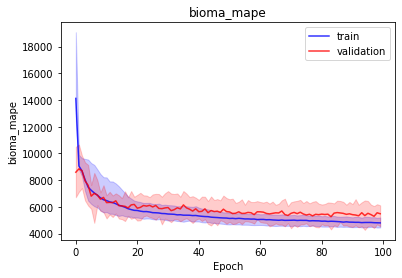

<b>bioma_BrayCurtis</b>: 0.1980 (min: 0.1895, max: 0.2142)

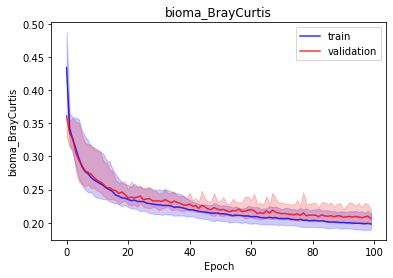

<b>bioma_pearson_corr</b>: 0.9253 (min: 0.9120, max: 0.9322)

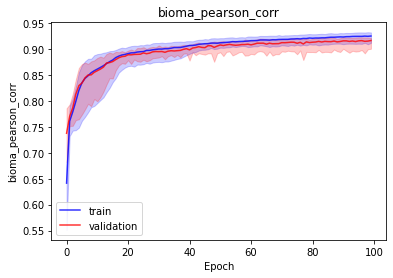

<b>bioma_jensen_shannon_divergence</b>: 0.3387 (min: 0.3120, max: 0.3820)

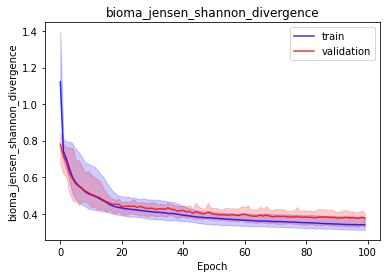

<b>domain_mse</b>: 0.0001 (min: 0.0001, max: 0.0001)

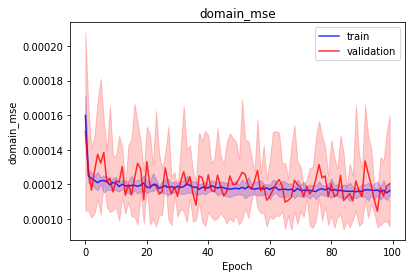

<b>domain_mae</b>: 0.0011 (min: 0.0011, max: 0.0012)

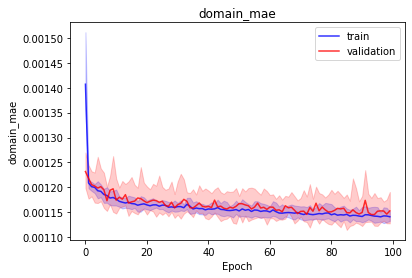

<b>domain_mape</b>: 8116.2993 (min: 7769.0068, max: 8412.1074)

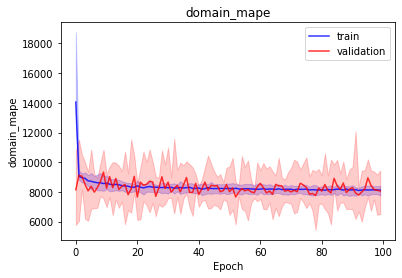

<b>domain_BrayCurtis</b>: 0.4110 (min: 0.4079, max: 0.4148)

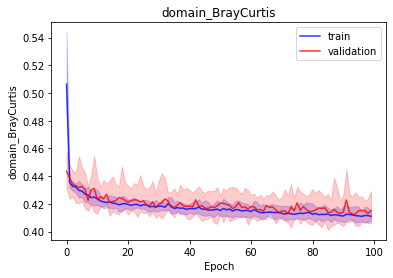

<b>domain_pearson_corr</b>: 0.7232 (min: 0.7150, max: 0.7292)

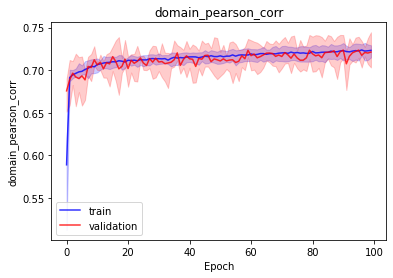

<b>domain_jensen_shannon_divergence</b>: 0.9057 (min: 0.8848, max: 0.9189)

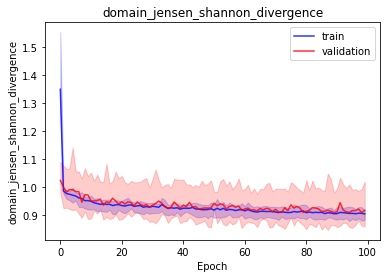

<b>latent_mae</b>: 0.0176 (min: 0.0162, max: 0.0197)

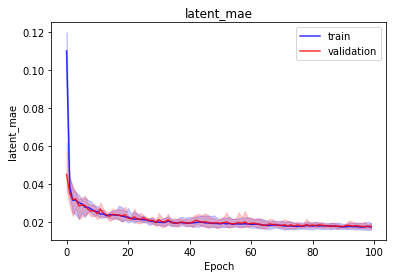

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.6266527135080329 | 0.6136061470671914 | 0.6406159775813023 |
| bioma_loss | 0.1977369338274002 | 0.18919871747493744 | 0.21405689418315887 |
| domain_loss | 0.41093119978904724 | 0.40780290961265564 | 0.41511303186416626 |
| latent_loss | 0.017621532082557678 | 0.01620849221944809 | 0.019728656858205795 |
| bioma_mse | 9.910229891829658e-06 | 8.597741725679953e-06 | 1.1326571438985411e-05 |
| bioma_mae | 0.0005465694121085107 | 0.0005230223177932203 | 0.0005924651050008833 |
| bioma_mape | 4800.50634765625 | 4455.94580078125 | 5211.95654296875 |
| bioma_BrayCurtis | 0.1979888677597046 | 0.189491406083107 | 0.21423104405403137 |
| bioma_pearson_corr | 0.925269603729248 | 0.9119724631309509 | 0.9321821928024292 |
| bioma_jensen_shannon_divergence | 0.33867451548576355 | 0.31198063492774963 | 0.3820110857486725 |
| domain_mse | 0.00011633735994109884 | 0.00011357424955349416 | 0.00012034739484079182 |
| domain_mae | 0.0011410440783947706 | 0.0011325104860588908 | 0.0011513774516060948 |
| domain_mape | 8116.29931640625 | 7769.0068359375 | 8412.107421875 |
| domain_BrayCurtis | 0.41103237867355347 | 0.40791523456573486 | 0.41482335329055786 |
| domain_pearson_corr | 0.7232025861740112 | 0.7149652242660522 | 0.7291947603225708 |
| domain_jensen_shannon_divergence | 0.9057055711746216 | 0.8847793936729431 | 0.9188774228096008 |
| latent_mae | 0.017631469294428825 | 0.016199490055441856 | 0.01974302902817726 |


*************

In [20]:
# Train the selected model (the best one from those with the smallest latent space (10)): no.351
experiment_metrics, models, results = perform_experiment_2(cv_folds=5, 
                        epochs=100, 
                        batch_size=64, 
                        learning_rate=0.001, 
                        optimizer=optimizers.Adam,
                        learning_rate_scheduler=None,
                        input_transform=Percentage,
                        output_transform=tf.keras.layers.Softmax,
                        reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None), 
                        latent_space=10, 
                        layers=[512,256],
                        activation='tanh', 
                        activation_latent='tanh', 
                        data_microbioma_train=data_microbioma_train,
                        data_domain_train=data_domain_train,
                        show_results=True, 
                        device='/CPU:0')

In [21]:
predictions = test_model_cv_predictions(models, Percentage, tf.keras.layers.Softmax, data_microbioma_test, data_domain_test)
#save_predictions(predictions, 'experiment_testSet_AE_combinedLatent_5CV_3var.txt')

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.4071604907512665 | 0.4071604907512665 | 0.4071604907512665 |
| pearson_corr | 0.721954345703125 | 0.721954345703125 | 0.721954345703125 |
| jensen_shannon_divergence | 0.8418271541595459 | 0.8418271541595459 | 0.8418271541595459 |


# 4. Auto-encoder OTU latent <a name="AE_latentOTU"></a>

In [6]:
from train_2 import *

### Get microbioma train data and numpy train objects

In [7]:
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = \
    read_df_with_transfer_learning_subset_fewerDomainFeatures(['age','Temperature','Precipitation3Days'])

In [8]:
data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

In [9]:
data_microbioma_train.shape

(4251, 717)

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 10 |
| Bioma Autoencoder | b -> 512 -> 256 -> 10 -> 256 -> 512 -> b |
| Domain Autoencoder |   |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 64 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>99</b></p>

<b>loss</b>: 0.1631 (min: 0.1631, max: 0.1631)

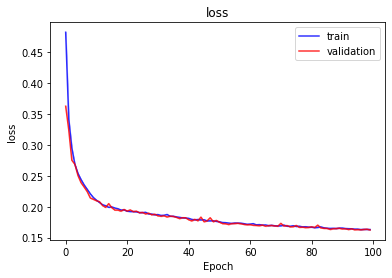

<b>bioma_mse</b>: 0.0000 (min: 0.0000, max: 0.0000)

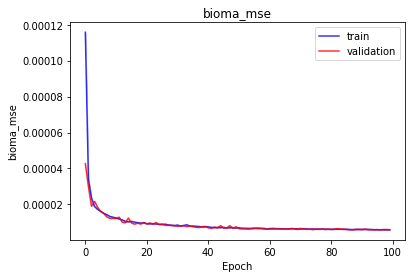

<b>bioma_mae</b>: 0.0004 (min: 0.0004, max: 0.0004)

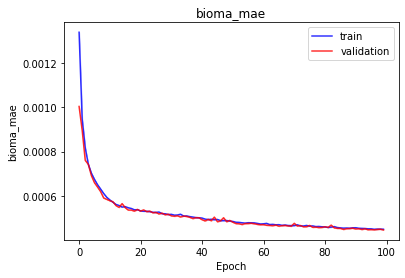

<b>bioma_mape</b>: 4060.0955 (min: 4060.0955, max: 4060.0955)

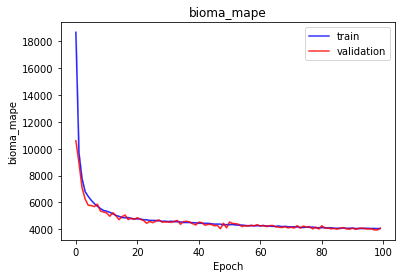

<b>bioma_BrayCurtis</b>: 0.1631 (min: 0.1631, max: 0.1631)

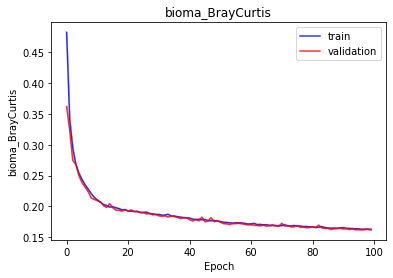

<b>bioma_pearson_corr</b>: 0.9495 (min: 0.9495, max: 0.9495)

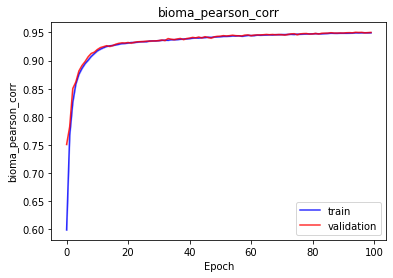

<b>bioma_jensen_shannon_divergence</b>: 0.2646 (min: 0.2646, max: 0.2646)

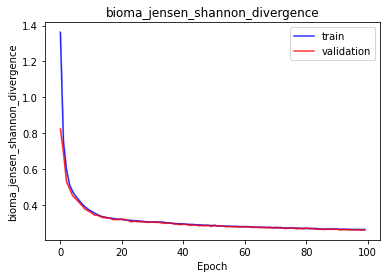

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.16313993290743248 | 0.16313993290743248 | 0.16313993290743248 |
| bioma_mse | 5.9371814131736755e-06 | 5.9371814131736755e-06 | 5.9371814131736755e-06 |
| bioma_mae | 0.00044932746095582843 | 0.00044932746095582843 | 0.00044932746095582843 |
| bioma_mape | 4060.095458984375 | 4060.095458984375 | 4060.095458984375 |
| bioma_BrayCurtis | 0.1631399542093277 | 0.1631399542093277 | 0.1631399542093277 |
| bioma_pearson_corr | 0.9494578838348389 | 0.9494578838348389 | 0.9494578838348389 |
| bioma_jensen_shannon_divergence | 0.264644593000412 | 0.264644593000412 | 0.264644593000412 |


*************

In [10]:
# Train the selected model (the best one from those with the smallest latent space (10)): no.351
experiment_metrics, models, results = perform_experiment_2(cv_folds=0, 
                        epochs=100, 
                        batch_size=64, 
                        learning_rate=0.001, 
                        optimizer=optimizers.Adam,
                        learning_rate_scheduler=None,
                        input_transform=Percentage,
                        output_transform=tf.keras.layers.Softmax,
                        reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None), 
                        latent_space=10, 
                        layers=[512,256],
                        activation='tanh', 
                        activation_latent='tanh', 
                        data_microbioma_train=data_microbioma_train,
                        data_domain_train=None,
                        show_results=True, 
                        device='/CPU:0')

### To get encoders and decoders to use in domain->latent model

In [11]:
model, encoder, _ ,decoder = models[0]

In [12]:
df_domain_train.shape

(4251, 3)

### To predict latent space for samples in domain->latent model

In [13]:
latent_train = encoder.predict(data_microbioma_train)
latent_test = encoder.predict(data_microbioma_test)

### To build model to predict latent space 

In [14]:
def model_fn_latent():
    in_layer = layers.Input(shape=(3,))
    net = layers.Dense(128, activation='tanh')(in_layer)
    net = layers.Dense(64, activation='tanh')(net)
    net = layers.Dense(32, activation='tanh')(net)
    net = layers.Dense(16, activation='tanh')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation=None)(net) # 'tanh already'
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.001), loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanSquaredError()])
    return model

In [15]:
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                            latent_train,
                            latent_train,
                            data_domain_train,
                            data_domain_train,
                            epochs=100,
                            batch_size=16,
                            verbose=-1)

In [16]:
print_results_noEnsemble(result_latent)

<p>Best iteration: <b>74</b></p>

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.060972585827830786 | 0.05935779990336105 | 0.08141214553975717 |
| domain_mean_squared_error | 0.06097258999943733 | 0.05935780704021454 | 0.081412173807621 |


In [17]:
# Test only Dense(domain->latent)
predictions = test_model_tl_latent(model_latent, latent_test, data_domain_test)
#save_predictions(predictions, 'experiment_testSet_domain-latent_AE_OTUlatent_3var.txt)

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| mse | 0.059301476925611496 | 3.3864054671539634e-08 | 1.0656218528747559 |


### Domain -> latent -> microbiome. Test set

In [18]:
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, data_microbioma_test, data_domain_test)

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.4181441366672516 | 0.4181441366672516 | 0.4181441366672516 |
| pearson_corr | 0.7348228096961975 | 0.7348228096961975 | 0.7348228096961975 |
| jensen_shannon_divergence | 0.8599598407745361 | 0.8599598407745361 | 0.8599598407745361 |


### Save model

In [21]:
decoder.save('decoder.h5')
model_latent.save('model_latent.h5')

In [22]:
new_decoder = tf.keras.models.load_model('decoder.h5')

In [23]:
new_model_latent = tf.keras.models.load_model('model_latent.h5')

In [30]:
predictions = test_model_tl_noEnsemble(new_model_latent, new_decoder, Percentage, tf.keras.layers.Softmax, data_microbioma_test, data_domain_test)

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.4181441366672516 | 0.4181441366672516 | 0.4181441366672516 |
| pearson_corr | 0.7348228096961975 | 0.7348228096961975 | 0.7348228096961975 |
| jensen_shannon_divergence | 0.8599598407745361 | 0.8599598407745361 | 0.8599598407745361 |
